In [2]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#pylustrator.start()
"Dynamical system of Neoantingen Vaccine for patients with melanoma "
"based on Marisabel et al (2021)"
def patientID(patient):
    "First step is to define the set of parameter and initial conditions per patient"    
    #patient = 6
    "Vaccine parameters"
    dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
    dose_p = dose_p_all[patient-1]
    h_p = dose_p 
    dose_a = 1*0.5 #mg/L it should 0.5 mg/ml
    h_a = dose_a
    alpha_p = 0.28 #1/day
    alpha_d = 0.5  #1/day
    V_sc = 4*0.1919 #L
    
    "Dendritic Cells"
    Lambda = 3.75 #1/day
    delta_M = 0.33 #1/day
    r_D = 2.48 #1/day
    K_a = 6.64 #1e3 # mg/L 
    K_DC = 2.38*1e7 #cells
    V_E = 1*1e-14 #L
    
    " Antigen processing and presentation"
    alleles_j = [4,3,3,4,4,3] 
    alleles_k = [4,3,4,4,3,2]
    n = alleles_j[patient-1]
    m = alleles_k[patient-1]
     
    N_A =6.02*(1e23) #1/mol
    alpha_Ep = 70 #1/day
    beta_p = 14.4 #1/day
    k_onj = 1.8144*(1e-2) #1/(pM*day) k_on1
    #K_DJ = 
    K_DJ_eff = [np.array([2022898.248, 2259523.473,	2167420.113, 1173316.913]),
                np.array([1484974.623, 2535151.868,	2284627.402]),
                np.array([2383016.796, 1526723.96, 1748749.88]),
                np.array([2022589.187, 3180789.851, 2759602.837, 2305265.682]),
                np.array([1663174.667, 1588701.641, 1749390.592, 1653025.941]),
                np.array([1927952.932, 1938657.991, 1253616.247])] # (sum(1/K_DJ[patient-1])**(-1))
    k_offj = k_onj*K_DJ_eff[patient-1]/1 # 1/day
    #K_DK = 
    K_DK_eff = [np.array([16081.17792, 271328.1446, 35471.5965, 33529.37879]),
                np.array([83978.51167, 31694.08875, 39710.93314]),
                np.array([23154.4359, 72622.70269, 4375.04084, 16491.62389]),
                np.array([19125.68472, 93663.04964, 53339.98855, 12503.98159]),
                np.array([96054.14771, 5452.233863, 8418.335798]),
                np.array([156840.5771, 96357.44993])]   
    #(sum(1/K_DK[patient-1])**(-1)) K_DJ and KD
    k_onk = 8.64*(1e-3) #1/(pM*day) k_on2
    k_offk = k_onk*K_DK_eff[patient-1]/1 #1/day
    
    "The values for the dissociation constant K_D,s were computed in the excel file "
    "patients_HLA_BA.xlsx were all the binding affinities for each peptide to MHC I/II "
    "were computed using NetMHCpan 4.0 and NetMHCIIpan 4.0"
    
    beta_M = 1.663 #1/day
    k_in = 14.4 #1/day
    k_ext = 28.8 #1/day
    beta_pM = 0.166 #1/day
    
    "T-cells "
    a = 5*(1e7) #cells
    a_1 = 1*1e3 #cells
    b_4 = 0.15 #1/day
    b_8 = 0.12 #1/day
    sigma_4 = 1.5 # 1/day
    sigma_8 = 3 #1/day
    K_TC = 8.57 * 1e11 #cells
    F_p4_all = np.array([0.006, 0.001, 0.001, 0.001, 0.003, 0.001])
    F_p8_all = np.array([0.007, 0.002, 0.006, 0.002, 0.002, 0.001]) 
    F_p4 = F_p4_all[patient-1]
    F_p8 = F_p8_all[patient-1]
    K_pM = 400
    c_all = [0.0156, 0.0084, 0.0448, 0.0056, 0.031, 5.55*1e-5] 
    c = c_all[patient-1] #1/day
    c_4_all = [0.04, 0.0105, 0.0487, 0.0467, 0.0327, 0.04224]
    c_4 = c_4_all[patient-1] #1/day
    c_8 = 6.5 * (1e-11) #1/day
    mu = 0.0029 #1/day
    mu_4 = 0.031 #1/day
    mu_8 = 0.022 #1/day
    rho_4 = 0.0265 #1/day
    rho_8 = 0.0509 #1/day
    
    " Tumor Cells "
    r = 0.004 #1/day
    K_T = 1.45 * (1e10) #cells
    d_all = np.array([0.068, 0.0196, 0.0649, 0.0617, 0.0525, 0.035])
    d = d_all[patient-1] #1/day
    lambda_all = np.array([0.978, 0.991, 1, 0, 0.8568, 1.141*1e-4])
    lambdaa = lambda_all[patient-1]
    s = 0.0839  
    
    "Initial Conditions"
    p0 = h_p 
    A_d0 = 1*dose_a * 1e3
    D_I0 = 1*(1e7)
    D_M0 = 0
    p_E0 = 0
    
    M_jE0 = np.array([2, 2, 1, 3.5])*1e17/N_A 
    pM_jE0 = 0
    pM_j0 = 0
    M_j0 = 0
    def z0j(i):
        z0j = [M_jE0[i],pM_jE0,pM_j0,M_j0]
        return z0j
    temp_z0j = []
    for i in range(n):    
        temp_z0j = np.concatenate((temp_z0j,z0j(i)))
    z0j = temp_z0j
    
    M_kE0 = np.array([1, 1, 0.5, 0.5])*1e17/N_A
    pM_kE0 = 0
    pM_k0 = 0
    M_k0 = 0
    def z0k(i):
        z0k = [M_kE0[i],pM_kE0,pM_k0,M_k0]
        return z0k
    temp_z0k = []
    for i in range(m):    
        temp_z0k = np.concatenate((temp_z0k,z0k(i)))
    z0k = temp_z0k
    
    T0 = [1.375*(1e6), 1.139*(1e9), 1.177*(1e6), 1.493*(1e6),
          858265, 1.078*(1e9)]
    N_CD40 = 0.7*(5.38*(1e9))
    N_CD80 = 0.3*(5.39*(1e9))
    A_CD40 = np.array([1.43,1.43,1.43,1.43, 1.43, 1.43])*1e0*0.7
    A_CD80 = np.array([1.43, 1.43, 1.43, 1.43, 1.43, 1.43])*1e0*0.3
    
    z0 = [p0, A_d0, D_I0, D_M0, p_E0]    
    z0 = np.concatenate((z0,z0j,z0k))
    z0 = np.concatenate((z0,[T0[patient-1], N_CD40, N_CD80, A_CD40[patient-1],
                             A_CD80[patient-1], A_CD40[patient-1]+A_CD80[patient-1]]))
    
    "Next we define the system of ODEs in Marisabel et al (2021)"
    def states(t,z):
        dotz = np.zeros(len(z))  #use np.zeros_like(z) for odeint  
        
        n = alleles_j[patient-1] # for alleles in MHC-I
        m = alleles_k[patient-1] # for alleles in MHC-II
        l = 4*(n+m) + 4 # number of equations up to this point
        
        #some functions for later
        
        pM_I = N_A * (np.sum(np.fromiter((z[7+i*4] for i in range(n)), float)))*1e-12
        pM_II = N_A* (np.sum(np.fromiter((z[4*n + 7 + i*4] for i in range(m)),float)))*1e-12
        
        # pM_I = N_A * (z[7] +z[11] + z[15] + z[19])*1e-12
        # pM_II = N_A * (z[23] +z[27] + z[31] + z[35])*1e-12
        
        Psi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II)/(pM_II+K_pM)
        Psi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I)/(pM_I+K_pM)
        Phi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II- K_pM)/(pM_II+K_pM)
        Phi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I - K_pM)/(pM_I+K_pM)
        
        "Vaccine peptide and adjuvant concentrations" 
        dotz[0] =  - alpha_p*z[0]
        dotz[1] =  - alpha_d*z[1]
        
        #dpdt =  - alpha_p*p
        #dA_ddt = - alpha_d*A_d
        
        "Antigen-presenting cells: Dendritic cells "
        dotz[2] = Lambda*z[2]*(1- z[2]/K_DC) - r_D*(z[1])/(K_a+z[1]) * z[2]
        dotz[3] = r_D* (z[1])/(K_a+z[1]) * z[2] - delta_M*z[3]
        
        # dD_Idt = Lambda*D_I*(1- D_I/K_DC) - (r_D*A_d)/(K_a+A_d) * D_I
        # dD_Mdt = (r_D*A_d)/(K_a+A_d) * D_I - delta_M*D_M
        
        "Antigen processing and presentation by mature DCs"
        dotz[4] = (alpha_Ep*z[0]*V_E/V_sc 
                   - z[4]/V_E *(k_onj* np.sum(np.fromiter((z[5+i*4]  for i in range(n)), float))
                                + k_onk* np.sum(np.fromiter((z[4*n + 5 + i*4] for i in range(m)),float)))
                   + np.sum(np.fromiter((k_offj[i]*z[6+i*4] for i in range(n)),float))
                   + np.sum(np.fromiter((k_offk[i]*z[4*n + 6 + i*4] for i in range(m)),float)) 
                   - beta_p*z[4])
        
        # dotz[4] = (alpha_Ep*z[0]*V_E/V_sc - z[4] * (k_onj*(z[5] + z[9]+ z[13] + z[17])
        #                                             + k_onk*(z[21] +z[25] + z[29] + z[33]))/V_E
        #            + (k_offj[patient-1][0]*z[6]+k_offj[patient-1][1]*z[10]+
        #               k_offj[patient-1][2]*z[14] + k_offj[patient-1][3]*z[18]) 
        #            + (k_offk[patient-1][0]*z[22]+k_offk[patient-1][1]*z[26]
        #               + k_offk[patient-1][2]*z[30] +k_offk[patient-1][3]*z[34]) - beta_p*z[4])
                                          
        
        # dp_Edt = alpha_Ep*p*V_E/V_sc - p_E * (k_onj*(M_jE/V_E) + k_onk*(M_kE/V_E)) 
        # + (k_offj*pM_jE + k_offk*pM_kE) - beta_p*p_E
        
        for i in range(n):
            j = 5+i*4
            j1 = j+1
            j2 = j1+1
            j3 = j2+1
            
            dotz[j] = (beta_M*(z0[j] - z[j]) - k_onj * z[4]*(z[j]/V_E) 
                       + k_offj[i]*z[j1] + k_in*z[j3])
            dotz[j1] = (k_onj* z[4]*(z[j]/V_E) - k_offj[i]*z[j1]
                        - beta_pM*z[j1] - k_ext*z[j1])
            dotz[j2] = (k_ext*z[j1] - k_offj[i]*z[j2])
            dotz[j3] = (k_offj[i]*z[j2] - k_in* z[j3])
        
        #dM_jEdt = beta_M*(M_jE0 - M_jE) - k_onj * z[4]*(M_jE/V_E) + k_offj*pM_jE 
        #+k_in*M_j
        #dpM_jEdt = k_onj* z[4]*(M_jE/V_E) - k_offj*pM_jE - beta_pM*pM_jE - k_ext*pM_jE
        #dpM_jdt = k_ext*pM_jE - k_offj*pM_j
        #dM_jdt = k_offj*pM_j - k_in* M_j
       
        for i in range(m): 
            k = 4*n + 5 + i*4 # 4*n is # eq in last loop 
            k1 = k+1
            k2 = k1+1
            k3 = k2+1
            
            dotz[k] = (beta_M*(z0[k] - z[k]) - k_onk * z[4]*(z[k]/V_E) 
                       + k_offk[i]*z[k1] + k_in*z[k3])
            dotz[k1] = (k_onk* z[4]*(z[k]/V_E) - k_offk[i]*z[k1] 
                        - beta_pM*z[k1] - k_ext*z[k1])
            dotz[k2] = (k_ext*z[k1] - k_offk[i]*z[k2])
            dotz[k3] = (k_offk[i]*z[k2] - k_in* z[k3])
           
        # dM_kEdt = beta_M*(M_kE0 - M_kE) - k_onk * z[4]*(M_kE/V_E) + k_offk*pM_kE 
        # +k_in*M_k 
        # dpM_kEdt = k_onk* z[4]*(M_kE/V_E) - k_offk*pM_kE - beta_pM*pM_kE - k_ext*pM_kE
        # dpM_kdt = k_ext*pM_kE - k_offk*pM_k
        # dM_kdt = k_offk*pM_k - k_in* M_k
        
        #l = 4*(n+m) + 4 # number of equations up to this point
        
        "Tumor Cells"
        D = d*((z[l+5]/z[l+1])**lambdaa)/(s+(z[l+5]/z[l+1])**lambdaa)
        #print(D)     
        dotz[l+1] = r*z[l+1]*(1-z[l+1]/K_T) - D*z[l+1]
        
        #dTdt = r*T*(1-T/K_T) - d*((A_CD8/T)**lambdaa)/(s+(A_CD8/T)**lambdaa)*T
        
        "Helper and Cytotoxic T cells"
        dotz[l+2] = (b_4*z[l+2]*(1-z[l+2]/(0.7*K_TC)) 
                     - sigma_4*F_p4*z[l+2]*Psi_4 - mu*z[l+2])
        dotz[l+3] = (b_8*z[l+3]*(1-z[l+3]/(0.3*K_TC)) 
                     - sigma_8*F_p8*z[l+3]*Psi_8 - mu*z[l+3])
        dotz[l+4] = (sigma_4*F_p4*z[l+2]*Psi_4 + rho_4*Phi_4 *z[l+4] 
                     + c_4*(z[l+1]/(a_1+z[l+1]))*z[l+4] - mu_4*z[l+4])
        dotz[l+5] = (c*(D**2*z[l+1]**2)/(a+D**2*z[l+1]**2)*z[l+5] + c_8*z[l+4]*z[l+1] 
                     + sigma_8*F_p8*z[l+3]*Psi_8 + rho_8*Phi_8 *z[l+5] - mu_8*z[l+5])
        
        # dN_CD4dt = b_4*N_CD4*(1-N_CD4/K_TC) - sigma_4*F_p4*N_CD4*Psi_4 - mu*N_CD4
        # dN_CD8dt = b_8*N_CD8*(1-N_CD8/K_TC) - sigma_8*F_p8*N_CD8*Psi_8 - mu*N_CD8
        # dA_CD4dt = sigma_4*F_p4*N_CD4*Psi_4 + rho_4*Phi_4*A_CD4 
        # + c_4*(T/(a_1+T))*A_CD4 - mu_4*A_CD4
        # dA_CD8dt = c*(d**2*T**2)/(a+d**2*T**2)*A_CD8 + c_8*A_CD4*T 
        # + sigma_8*F_p8*N_CD8*Psi_8 + rho_8*Phi_8*A_CD8 - mu_8*A_CD8
        
        "DE for total T-cells"
        dotz[l+6] = dotz[l+4] + dotz[l+5]
        return dotz
    "Solving the STIFF system of ODEs using solve_ivp solver from scipy.integrate library "
    steps = 200
    Tfinal = 200
    method = 'Radau'#'BDF' #'LSODA'# <- these are methods for stiff problems #'RK45' 
    tau = [0,3,7,14,21,83,139] #prime and booster days. The last two days are boosters 
    t_all = [np.linspace(tau[0], tau[1],int(steps*0.5)), np.linspace(tau[1], tau[2],int(steps*0.5)),
             np.linspace(tau[2], tau[3],int(steps*0.5)), np.linspace(tau[3], tau[4],int(steps*2)),
             np.linspace(tau[4], tau[5],int(steps*2)), np.linspace(tau[5], tau[6],int(steps*2)),
             np.linspace(tau[6], Tfinal,int(steps*2))]
    
    sol = solve_ivp(states,[tau[0],tau[1]],z0,method = method,dense_output=True)
    t = t_all[0]
    z_0 = sol.sol(t)
    z_0 = np.transpose(z_0)
    z_0[len(t_all[0])-1][0:2] = z_0[len(t_all[0])-1][0:2] + [h_p, A_d0]
    z0 = z_0[len(t_all[0])-1]
    
    sol = solve_ivp(states,[tau[1],tau[2]],z0,method = method,dense_output=True)
    t = t_all[1]
    z_1 = sol.sol(t)
    z_1 = np.transpose(z_1)
    z_1[len(t_all[1])-1][0:2] = z_0[len(t_all[1])-1][0:2] + [h_p, A_d0]
    z0 = z_1[len(t_all[1])-1]
    temp = np.append(np.transpose(z_0),np.transpose(z_1),axis=1)
    
    sol = solve_ivp(states,[tau[2],tau[3]],z0,method = method,dense_output=True)
    t = t_all[2]
    z_2 = sol.sol(t)
    z_2 = np.transpose(z_2)
    z_2[len(t_all[2])-1][0:2] = z_2[len(t_all[2])-1][0:2] + [h_p, A_d0]
    z0 = z_2[len(t_all[2])-1]
    temp = np.append(temp,np.transpose(z_2),axis=1)
    
    sol = solve_ivp(states,[tau[3],tau[4]],z0,method = method, dense_output=True)
    t = t_all[3]
    z_3 = sol.sol(t)
    z_3 = np.transpose(z_3)
    z_3[len(t_all[3])-1][0:2] = z_3[len(t_all[3])-1][0:2] + [h_p, A_d0]
    z0 = z_3[len(t_all[3])-1]
    temp = np.append(temp,np.transpose(z_3),axis=1)
    
    sol = solve_ivp(states,[tau[4],tau[5]],z0,method = method,dense_output=True)
    t = t_all[4]
    z_4 = sol.sol(t)
    z_4 = np.transpose(z_4)
    z_4[len(t_all[4])-1][0:2] = z_4[len(t_all[4])-1][0:2] + [h_p, A_d0]
    z0 = z_4[len(t_all[4])-1]
    temp = np.append(temp,np.transpose(z_4),axis=1)
    
    sol = solve_ivp(states,[tau[5],tau[6]],z0,method = method,dense_output=True)
    t = t_all[5]
    z_5 = sol.sol(t)
    z_5 = np.transpose(z_5)
    z_5[len(t_all[5])-1][0:2] = z_5[len(t_all[5])-1][0:2] + [h_p, A_d0]
    z0 = z_5[len(t_all[5])-1]
    temp = np.append(temp,np.transpose(z_5),axis=1)
    
    sol = solve_ivp(states,[tau[6],Tfinal],z0,method = method,dense_output=True)
    t = t_all[6]
    z_6 = sol.sol(t)
    z_6 = np.transpose(z_6)
    temp = np.append(temp,np.transpose(z_6),axis=1)
    
    #for i in range(len(temp)):
    #    if min(temp[i])<0:
    #        print('The state temp['+str(i)+'] has negative entries')
            
    l = 4*(n + m + 1) 
    "Plotting the solutions for T-cells and Tumor cells"
    t = np.r_[t_all[0],t_all[1],t_all[2],t_all[3],t_all[4],t_all[5],t_all[6]]
    
    # z = temp
    # return [k_offj,k_offk,t,N_A,n,m,z]
    
    [T, N_CD4, N_CD8, A_CD4, A_CD8,Total_Tcells] = temp[l+1:len(temp)]

    return [t, T, N_CD4, N_CD8, A_CD4, A_CD8,Total_Tcells]

In [ ]:
rt numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#pylustrator.start()
"Dynamical system of Neoantingen Vaccine for patients with melanoma "
"based on Marisabel et al (2021)"
def patientID(patient):
    "First step is to define the set of parameter and initial conditions per patient"    
    #patient = 6
    "Vaccine parameters"
    dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
    dose_p = dose_p_all[patient-1]
    h_p = dose_p 
    dose_a = 1*0.5 #mg/L it should 0.5 mg/ml
    h_a = dose_a
    alpha_p = 0.28 #1/day
    alpha_d = 0.5  #1/day
    V_sc = 4*0.1919 #L
    
    "Dendritic Cells"
    Lambda = 3.75 #1/day
    delta_M = 0.33 #1/day
    r_D = 2.48 #1/day
    K_a = 6.64 #1e3 # mg/L 
    K_DC = 2.38*1e7 #cells
    V_E = 1*1e-14 #L
    
    " Antigen processing and presentation"
    alleles_j = [4,3,3,4,4,3] 
    alleles_k = [4,3,4,4,3,2]
    n = alleles_j[patient-1]
    m = alleles_k[patient-1]
     
    N_A =6.02*(1e23) #1/mol
    alpha_Ep = 70 #1/day
    beta_p = 14.4 #1/day
    k_onj = 1.8144*(1e-2) #1/(pM*day) k_on1
    #K_DJ = 
    K_DJ_eff = [np.array([2022898.248, 2259523.473,	2167420.113, 1173316.913]),
                np.array([1484974.623, 2535151.868,	2284627.402]),
                np.array([2383016.796, 1526723.96, 1748749.88]),
                np.array([2022589.187, 3180789.851, 2759602.837, 2305265.682]),
                np.array([1663174.667, 1588701.641, 1749390.592, 1653025.941]),
                np.array([1927952.932, 1938657.991, 1253616.247])] # (sum(1/K_DJ[patient-1])**(-1))
    k_offj = k_onj*K_DJ_eff[patient-1]/1 # 1/day
    #K_DK = 
    K_DK_eff = [np.array([16081.17792, 271328.1446, 35471.5965, 33529.37879]),
                np.array([83978.51167, 31694.08875, 39710.93314]),
                np.array([23154.4359, 72622.70269, 4375.04084, 16491.62389]),
                np.array([19125.68472, 93663.04964, 53339.98855, 12503.98159]),
                np.array([96054.14771, 5452.233863, 8418.335798]),
                np.array([156840.5771, 96357.44993])]   
    #(sum(1/K_DK[patient-1])**(-1)) K_DJ and KD
    k_onk = 8.64*(1e-3) #1/(pM*day) k_on2
    k_offk = k_onk*K_DK_eff[patient-1]/1 #1/day
    
    "The values for the dissociation constant K_D,s were computed in the excel file "
    "patients_HLA_BA.xlsx were all the binding affinities for each peptide to MHC I/II "
    "were computed using NetMHCpan 4.0 and NetMHCIIpan 4.0"
    
    beta_M = 1.663 #1/day
    k_in = 14.4 #1/day
    k_ext = 28.8 #1/day
    beta_pM = 0.166 #1/day
    
    "T-cells "
    a = 5*(1e7) #cells
    a_1 = 1*1e3 #cells
    b_4 = 0.15 #1/day
    b_8 = 0.12 #1/day
    sigma_4 = 1.5 # 1/day
    sigma_8 = 3 #1/day
    K_TC = 8.57 * 1e11 #cells
    F_p4_all = np.array([0.006, 0.001, 0.001, 0.001, 0.003, 0.001])
    F_p8_all = np.array([0.007, 0.002, 0.006, 0.002, 0.002, 0.001]) 
    F_p4 = F_p4_all[patient-1]
    F_p8 = F_p8_all[patient-1]
    K_pM = 400
    c_all = [0.0156, 0.0084, 0.0448, 0.0056, 0.031, 5.55*1e-5] 
    c = c_all[patient-1] #1/day
    c_4_all = [0.04, 0.0105, 0.0487, 0.0467, 0.0327, 0.04224]
    c_4 = c_4_all[patient-1] #1/day
    c_8 = 6.5 * (1e-11) #1/day
    mu = 0.0029 #1/day
    mu_4 = 0.031 #1/day
    mu_8 = 0.022 #1/day
    rho_4 = 0.0265 #1/day
    rho_8 = 0.0509 #1/day
    
    " Tumor Cells "
    r = 0.004 #1/day
    K_T = 1.45 * (1e10) #cells
    d_all = np.array([0.068, 0.0196, 0.0649, 0.0617, 0.0525, 0.035])
    d = d_all[patient-1] #1/day
    lambda_all = np.array([0.978, 0.991, 1, 0, 0.8568, 1.141*1e-4])
    lambdaa = lambda_all[patient-1]
    s = 0.0839  
    
    "Initial Conditions"
    p0 = h_p 
    A_d0 = 1*dose_a * 1e3
    D_I0 = 1*(1e7)
    D_M0 = 0
    p_E0 = 0
    
    M_jE0 = np.array([2, 2, 1, 3.5])*1e17/N_A 
    pM_jE0 = 0
    pM_j0 = 0
    M_j0 = 0
    def z0j(i):
        z0j = [M_jE0[i],pM_jE0,pM_j0,M_j0]
        return z0j
    temp_z0j = []
    for i in range(n):    
        temp_z0j = np.concatenate((temp_z0j,z0j(i)))
    z0j = temp_z0j
    
    M_kE0 = np.array([1, 1, 0.5, 0.5])*1e17/N_A
    pM_kE0 = 0
    pM_k0 = 0
    M_k0 = 0
    def z0k(i):
        z0k = [M_kE0[i],pM_kE0,pM_k0,M_k0]
        return z0k
    temp_z0k = []
    for i in range(m):    
        temp_z0k = np.concatenate((temp_z0k,z0k(i)))
    z0k = temp_z0k
    
    T0 = [1.375*(1e6), 1.139*(1e9), 1.177*(1e6), 1.493*(1e6),
          858265, 1.078*(1e9)]
    N_CD40 = 0.7*(5.38*(1e9))
    N_CD80 = 0.3*(5.39*(1e9))
    A_CD40 = np.array([1.43,1.43,1.43,1.43, 1.43, 1.43])*1e0*0.7
    A_CD80 = np.array([1.43, 1.43, 1.43, 1.43, 1.43, 1.43])*1e0*0.3
    
    z0 = [p0, A_d0, D_I0, D_M0, p_E0]    
    z0 = np.concatenate((z0,z0j,z0k))
    z0 = np.concatenate((z0,[T0[patient-1], N_CD40, N_CD80, A_CD40[patient-1],
                             A_CD80[patient-1], A_CD40[patient-1]+A_CD80[patient-1]]))
    
    "Next we define the system of ODEs in Marisabel et al (2021)"
    def states(t,z):
        dotz = np.zeros(len(z))  #use np.zeros_like(z) for odeint  
        
        n = alleles_j[patient-1] # for alleles in MHC-I
        m = alleles_k[patient-1] # for alleles in MHC-II
        l = 4*(n+m) + 4 # number of equations up to this point
        
        #some functions for later
        
        pM_I = N_A * (np.sum(np.fromiter((z[7+i*4] for i in range(n)), float)))*1e-12
        pM_II = N_A* (np.sum(np.fromiter((z[4*n + 7 + i*4] for i in range(m)),float)))*1e-12
        
        # pM_I = N_A * (z[7] +z[11] + z[15] + z[19])*1e-12
        # pM_II = N_A * (z[23] +z[27] + z[31] + z[35])*1e-12
        
        Psi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II)/(pM_II+K_pM)
        Psi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I)/(pM_I+K_pM)
        Phi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II- K_pM)/(pM_II+K_pM)
        Phi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I - K_pM)/(pM_I+K_pM)
        
        "Vaccine peptide and adjuvant concentrations" 
        dotz[0] =  - alpha_p*z[0]
        dotz[1] =  - alpha_d*z[1]
        
        #dpdt =  - alpha_p*p
        #dA_ddt = - alpha_d*A_d
        
        "Antigen-presenting cells: Dendritic cells "
        dotz[2] = Lambda*z[2]*(1- z[2]/K_DC) - r_D*(z[1])/(K_a+z[1]) * z[2]
        dotz[3] = r_D* (z[1])/(K_a+z[1]) * z[2] - delta_M*z[3]
        
        # dD_Idt = Lambda*D_I*(1- D_I/K_DC) - (r_D*A_d)/(K_a+A_d) * D_I
        # dD_Mdt = (r_D*A_d)/(K_a+A_d) * D_I - delta_M*D_M
        
        "Antigen processing and presentation by mature DCs"
        dotz[4] = (alpha_Ep*z[0]*V_E/V_sc 
                   - z[4]/V_E *(k_onj* np.sum(np.fromiter((z[5+i*4]  for i in range(n)), float))
                                + k_onk* np.sum(np.fromiter((z[4*n + 5 + i*4] for i in range(m)),float)))
                   + np.sum(np.fromiter((k_offj[i]*z[6+i*4] for i in range(n)),float))
                   + np.sum(np.fromiter((k_offk[i]*z[4*n + 6 + i*4] for i in range(m)),float)) 
                   - beta_p*z[4])
        
        # dotz[4] = (alpha_Ep*z[0]*V_E/V_sc - z[4] * (k_onj*(z[5] + z[9]+ z[13] + z[17])
        #                                             + k_onk*(z[21] +z[25] + z[29] + z[33]))/V_E
        #            + (k_offj[patient-1][0]*z[6]+k_offj[patient-1][1]*z[10]+
        #               k_offj[patient-1][2]*z[14] + k_offj[patient-1][3]*z[18]) 
        #            + (k_offk[patient-1][0]*z[22]+k_offk[patient-1][1]*z[26]
        #               + k_offk[patient-1][2]*z[30] +k_offk[patient-1][3]*z[34]) - beta_p*z[4])
                                          
        
        # dp_Edt = alpha_Ep*p*V_E/V_sc - p_E * (k_onj*(M_jE/V_E) + k_onk*(M_kE/V_E)) 
        # + (k_offj*pM_jE + k_offk*pM_kE) - beta_p*p_E
        
        for i in range(n):
            j = 5+i*4
            j1 = j+1
            j2 = j1+1
            j3 = j2+1
            
            dotz[j] = (beta_M*(z0[j] - z[j]) - k_onj * z[4]*(z[j]/V_E) 
                       + k_offj[i]*z[j1] + k_in*z[j3])
            dotz[j1] = (k_onj* z[4]*(z[j]/V_E) - k_offj[i]*z[j1]
                        - beta_pM*z[j1] - k_ext*z[j1])
            dotz[j2] = (k_ext*z[j1] - k_offj[i]*z[j2])
            dotz[j3] = (k_offj[i]*z[j2] - k_in* z[j3])
        
        #dM_jEdt = beta_M*(M_jE0 - M_jE) - k_onj * z[4]*(M_jE/V_E) + k_offj*pM_jE 
        #+k_in*M_j
        #dpM_jEdt = k_onj* z[4]*(M_jE/V_E) - k_offj*pM_jE - beta_pM*pM_jE - k_ext*pM_jE
        #dpM_jdt = k_ext*pM_jE - k_offj*pM_j
        #dM_jdt = k_offj*pM_j - k_in* M_j
       
        for i in range(m): 
            k = 4*n + 5 + i*4 # 4*n is # eq in last loop 
            k1 = k+1
            k2 = k1+1
            k3 = k2+1
            
            dotz[k] = (beta_M*(z0[k] - z[k]) - k_onk * z[4]*(z[k]/V_E) 
                       + k_offk[i]*z[k1] + k_in*z[k3])
            dotz[k1] = (k_onk* z[4]*(z[k]/V_E) - k_offk[i]*z[k1] 
                        - beta_pM*z[k1] - k_ext*z[k1])
            dotz[k2] = (k_ext*z[k1] - k_offk[i]*z[k2])
            dotz[k3] = (k_offk[i]*z[k2] - k_in* z[k3])
           
        # dM_kEdt = beta_M*(M_kE0 - M_kE) - k_onk * z[4]*(M_kE/V_E) + k_offk*pM_kE 
        # +k_in*M_k 
        # dpM_kEdt = k_onk* z[4]*(M_kE/V_E) - k_offk*pM_kE - beta_pM*pM_kE - k_ext*pM_kE
        # dpM_kdt = k_ext*pM_kE - k_offk*pM_k
        # dM_kdt = k_offk*pM_k - k_in* M_k
        
        #l = 4*(n+m) + 4 # number of equations up to this point
        
        "Tumor Cells"
        D = d*((z[l+5]/z[l+1])**lambdaa)/(s+(z[l+5]/z[l+1])**lambdaa)
        #print(D)     
        dotz[l+1] = r*z[l+1]*(1-z[l+1]/K_T) - D*z[l+1]
        
        #dTdt = r*T*(1-T/K_T) - d*((A_CD8/T)**lambdaa)/(s+(A_CD8/T)**lambdaa)*T
        
        "Helper and Cytotoxic T cells"
        dotz[l+2] = (b_4*z[l+2]*(1-z[l+2]/(0.7*K_TC)) 
                     - sigma_4*F_p4*z[l+2]*Psi_4 - mu*z[l+2])
        dotz[l+3] = (b_8*z[l+3]*(1-z[l+3]/(0.3*K_TC)) 
                     - sigma_8*F_p8*z[l+3]*Psi_8 - mu*z[l+3])
        dotz[l+4] = (sigma_4*F_p4*z[l+2]*Psi_4 + rho_4*Phi_4 *z[l+4] 
                     + c_4*(z[l+1]/(a_1+z[l+1]))*z[l+4] - mu_4*z[l+4])
        dotz[l+5] = (c*(D**2*z[l+1]**2)/(a+D**2*z[l+1]**2)*z[l+5] + c_8*z[l+4]*z[l+1] 
                     + sigma_8*F_p8*z[l+3]*Psi_8 + rho_8*Phi_8 *z[l+5] - mu_8*z[l+5])
        
        # dN_CD4dt = b_4*N_CD4*(1-N_CD4/K_TC) - sigma_4*F_p4*N_CD4*Psi_4 - mu*N_CD4
        # dN_CD8dt = b_8*N_CD8*(1-N_CD8/K_TC) - sigma_8*F_p8*N_CD8*Psi_8 - mu*N_CD8
        # dA_CD4dt = sigma_4*F_p4*N_CD4*Psi_4 + rho_4*Phi_4*A_CD4 
        # + c_4*(T/(a_1+T))*A_CD4 - mu_4*A_CD4
        # dA_CD8dt = c*(d**2*T**2)/(a+d**2*T**2)*A_CD8 + c_8*A_CD4*T 
        # + sigma_8*F_p8*N_CD8*Psi_8 + rho_8*Phi_8*A_CD8 - mu_8*A_CD8
        
        "DE for total T-cells"
        dotz[l+6] = dotz[l+4] + dotz[l+5]
        return dotz
    "Solving the STIFF system of ODEs using solve_ivp solver from scipy.integrate library "
    steps = 200
    Tfinal = 200
    method = 'Radau'#'BDF' #'LSODA'# <- these are methods for stiff problems #'RK45' 
    tau = [0,3,7,14,21,83,139] #prime and booster days. The last two days are boosters 
    t_all = [np.linspace(tau[0], tau[1],int(steps*0.5)), np.linspace(tau[1], tau[2],int(steps*0.5)),
             np.linspace(tau[2], tau[3],int(steps*0.5)), np.linspace(tau[3], tau[4],int(steps*2)),
             np.linspace(tau[4], tau[5],int(steps*2)), np.linspace(tau[5], tau[6],int(steps*2)),
             np.linspace(tau[6], Tfinal,int(steps*2))]
    
    sol = solve_ivp(states,[tau[0],tau[1]],z0,method = method,dense_output=True)
    t = t_all[0]
    z_0 = sol.sol(t)
    z_0 = np.transpose(z_0)
    z_0[len(t_all[0])-1][0:2] = z_0[len(t_all[0])-1][0:2] + [h_p, A_d0]
    z0 = z_0[len(t_all[0])-1]
    
    sol = solve_ivp(states,[tau[1],tau[2]],z0,method = method,dense_output=True)
    t = t_all[1]
    z_1 = sol.sol(t)
    z_1 = np.transpose(z_1)
    z_1[len(t_all[1])-1][0:2] = z_0[len(t_all[1])-1][0:2] + [h_p, A_d0]
    z0 = z_1[len(t_all[1])-1]
    temp = np.append(np.transpose(z_0),np.transpose(z_1),axis=1)
    
    sol = solve_ivp(states,[tau[2],tau[3]],z0,method = method,dense_output=True)
    t = t_all[2]
    z_2 = sol.sol(t)
    z_2 = np.transpose(z_2)
    z_2[len(t_all[2])-1][0:2] = z_2[len(t_all[2])-1][0:2] + [h_p, A_d0]
    z0 = z_2[len(t_all[2])-1]
    temp = np.append(temp,np.transpose(z_2),axis=1)
    
    sol = solve_ivp(states,[tau[3],tau[4]],z0,method = method, dense_output=True)
    t = t_all[3]
    z_3 = sol.sol(t)
    z_3 = np.transpose(z_3)
    z_3[len(t_all[3])-1][0:2] = z_3[len(t_all[3])-1][0:2] + [h_p, A_d0]
    z0 = z_3[len(t_all[3])-1]
    temp = np.append(temp,np.transpose(z_3),axis=1)
    
    sol = solve_ivp(states,[tau[4],tau[5]],z0,method = method,dense_output=True)
    t = t_all[4]
    z_4 = sol.sol(t)
    z_4 = np.transpose(z_4)
    z_4[len(t_all[4])-1][0:2] = z_4[len(t_all[4])-1][0:2] + [h_p, A_d0]
    z0 = z_4[len(t_all[4])-1]
    temp = np.append(temp,np.transpose(z_4),axis=1)
    
    sol = solve_ivp(states,[tau[5],tau[6]],z0,method = method,dense_output=True)
    t = t_all[5]
    z_5 = sol.sol(t)
    z_5 = np.transpose(z_5)
    z_5[len(t_all[5])-1][0:2] = z_5[len(t_all[5])-1][0:2] + [h_p, A_d0]
    z0 = z_5[len(t_all[5])-1]
    temp = np.append(temp,np.transpose(z_5),axis=1)
    
    sol = solve_ivp(states,[tau[6],Tfinal],z0,method = method,dense_output=True)
    t = t_all[6]
    z_6 = sol.sol(t)
    z_6 = np.transpose(z_6)
    temp = np.append(temp,np.transpose(z_6),axis=1)
    
    #for i in range(len(temp)):
    #    if min(temp[i])<0:
    #        print('The state temp['+str(i)+'] has negative entries')
            
    l = 4*(n + m + 1) 
    "Plotting the solutions for T-cells and Tumor cells"
    t = np.r_[t_all[0],t_all[1],t_all[2],t_all[3],t_all[4],t_all[5],t_all[6]]
    
    # z = temp
    # return [k_offj,k_offk,t,N_A,n,m,z]
    
    [T, N_CD4, N_CD8, A_CD4, A_CD8,Total_Tcells] = temp[l+1:len(temp)]

    return [t, T, N_CD4, N_CD8, A_CD4, A_CD8,Total_Tcells]

0
1
2
3
4
5


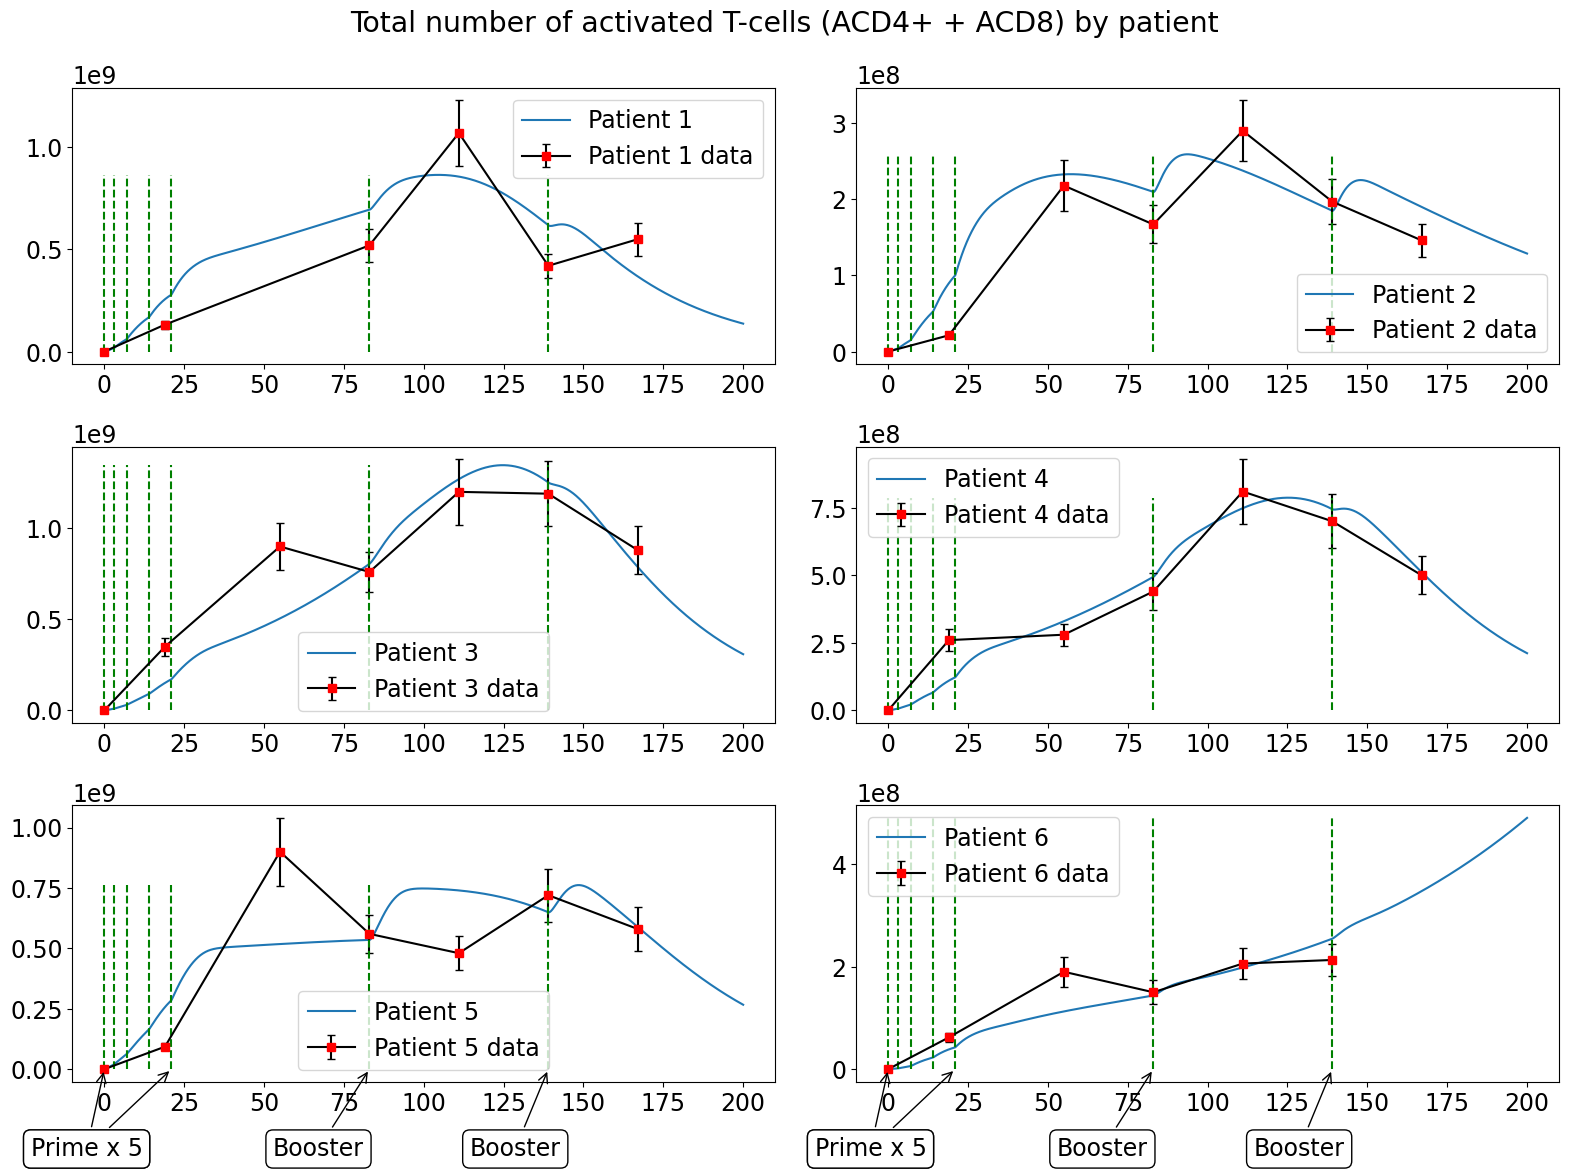

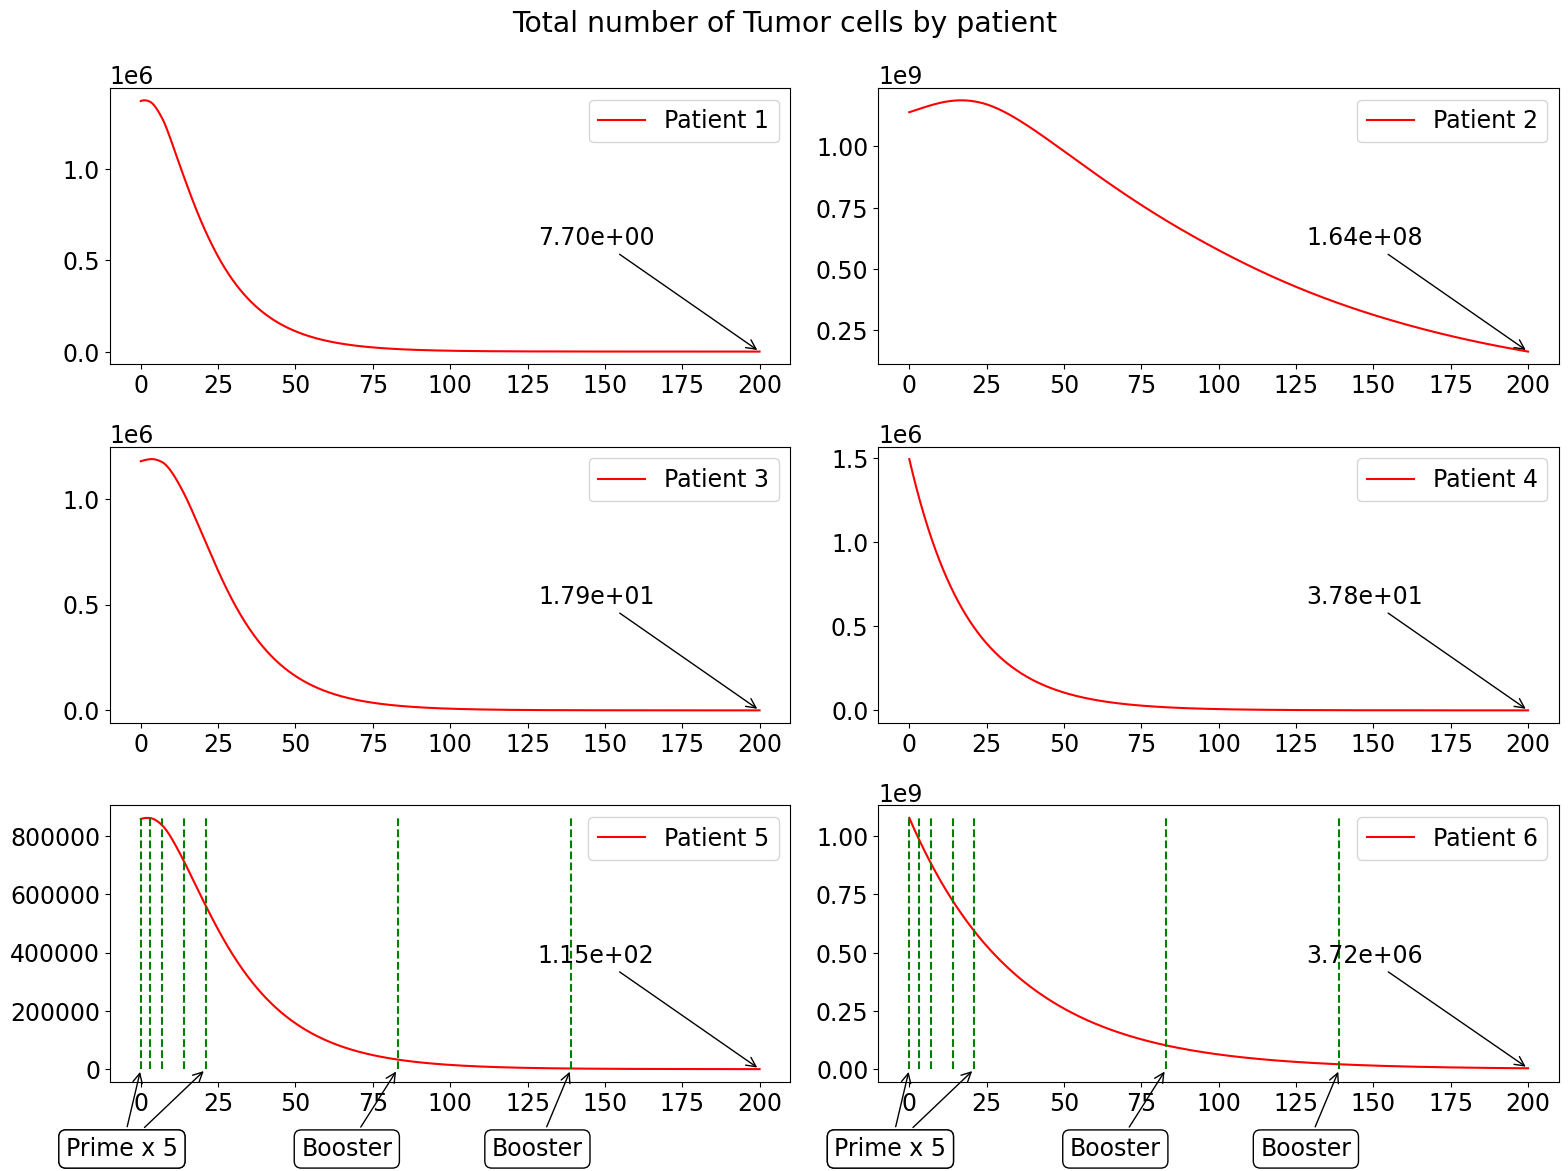

In [3]:
patients = {}
for i in range(6):
    print(i)
    patients[i] = patientID(i+1)
t1 = np.array([0,19,83,111,139,167])
t2 = np.array([0,19,55,83,111,139,167])
t3 = np.array([0,19,55,83,111,139])
t_data = [t1,t2,t2,t2,t2,t3]
patients_data = [np.array([0,92.4,361.1,750,294.6,381.7]),
                 np.array([0,14.9,152.8,116.9,204,137.8,102.379]),
                 np.array([0,242.4,628.1,531.7,838.1,834.8,614.2]),
                 np.array([0,180.3,194.9,308.3,563.6,488.7,348.8]),
                 np.array([0,65.2,631.8,388.8,338.8,503.9,406.1]),
                 np.array([0,43.3,133.3,105.3,144,149.3])]                                        

pest = [np.array([1.43,1.32*1e8,5.2*1e8,1.07*1e9,4.2*1e8,5.5*1e8]),
        np.array([1.43,2.14*1e7,2.18*1e8,1.67*1e8,2.9*1e8,1.97*1e8,1.46*1e8]),
        np.array([1.43,3.5*1e8,9*1e8,7.6*1e8,1.2*1e9,1.19*1e9,8.8*1e8]),
        np.array([1.43,2.6*1e8,2.8*1e8,4.4*1e8,8.1*1e8,7*1e8,5*1e8]),
        np.array([1.43,9.3*1e7,9*1e8,5.6*1e8,4.8*1e8,7.2*1e8,5.8*1e8]),
        np.array([1.43,6.2*1e7,1.9*1e8,1.5*1e8,2.06*1e8,2.13*1e8])]
        
        
err = [np.array([0.21,0.20*1e8,0.8*1e8,0.16*1e9,0.6*1e8,0.8*1e8]),
       np.array([0.21,0.32*1e7,0.33*1e8,0.25*1e8,0.4*1e8,0.3*1e8,0.22*1e8]),
       np.array([0.21,0.5*1e8,1.3*1e8,1.1*1e8,0.18*1e9,0.18*1e9,1.3*1e8]),
       np.array([0.21,0.4*1e8,0.4*1e8,0.7*1e8,1.2*1e8,1*1e8,0.7*1e8]),
       np.array([0.21,1.4*1e7,1.4*1e8,0.8*1e8,0.7*1e8,1.1*1e8,0.9*1e8]),
       np.array([0.21,0.9*1e7,0.29*1e8,0.23*1e8,0.31*1e8,0.32*1e8])]

'Total number of activated T-cells (ACD4+ + ACD8) by patient'
tau = [0,3,7,14,21,83,139]
plt.rcParams.update({'font.size': 17,})
fig, axs = plt.subplots(3, 2,figsize=(16,12))
fig.suptitle('Total number of activated T-cells (ACD4+ + ACD8) by patient')
for i in range(len(axs.flat)):
    if i<4:
        axs.flat[i].plot(patients[i][0], patients[i][6], label = 'Patient '+str(i+1))
        axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                             label= 'Patient '+ str(i+1)+' data',color = 'black',
                             capsize=3,marker = 's',mfc='red',mec='red')
        axs.flat[i].legend(loc='best')
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(patients[i][6]),
                           colors= 'g',linestyle = '--')
    else:
        axs.flat[i].plot(patients[i][0], patients[i][6], label = 'Patient '+str(i+1))
        axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                             label= 'Patient '+ str(i+1)+' data',color = 'black',
                             capsize=3,marker = 's',mfc='red',mec='red')
        axs.flat[i].legend(loc='best')
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(patients[i][6]), colors= 'g',linestyle = '--')
        axs.flat[i].annotate('Prime x 5', xy=(tau[0], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[4], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[5], 0 ), xycoords='data',
                             xytext=(tau[5]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[6], 0 ), xycoords='data',
                             xytext=(tau[6]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
fig.tight_layout()

'Total number of Tumor cells by patient'
tau = [0,3,7,14,21,83,139]
plt.rcParams.update({'font.size': 17,})
fig, axs = plt.subplots(3, 2,figsize=(16,12))
fig.suptitle('Total number of Tumor cells by patient')
for i in range(len(axs.flat)):
    if i<4:
        axs.flat[i].plot(patients[i][0], patients[i][1], color = 'red', label = 'Patient '+str(i+1))
        axs.flat[i].legend(loc='best')
        b = str('{:.2e}'.format(patients[i][1][len(patients[i][0])-1]))
        fT = patients[i][1][len(patients[i][0])-1]
        axs.flat[i].annotate(b, xy=(200, fT ), xycoords='data',
                             xytext=(0.8, 0.5), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle='->'),
                             horizontalalignment='right', verticalalignment='top')
        #axs.flat[i].set_ylim(0,)
    else:
        axs.flat[i].plot(patients[i][0], patients[i][1], color = 'red', label = 'Patient '+str(i+1))
        axs.flat[i].legend(loc='best')
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(patients[i][1]), colors= 'g',linestyle = '--')
        b = str('{:.2e}'.format(patients[i][1][len(patients[i][0])-1]))
        fT = patients[i][1][len(patients[i][0])-1]
        axs.flat[i].annotate(b, xy=(200, fT ), xycoords='data',
                             xytext=(0.8, 0.5), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle='->'),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[0], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[4], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[5], 0 ), xycoords='data',
                             xytext=(tau[5]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[6], 0 ), xycoords='data',
                             xytext=(tau[6]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
fig.tight_layout()